# Lending Club Data: Loan Risk Prediction Model

### Models

### Import required Python library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_columns', None)

# Ploting options
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Panda version: {pd.__version__}')

Panda version: 1.0.3


In [3]:
def confusion_matrix_display(model, title):
    plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['Fully Paid','Charged Off'],

                                 cmap=plt.cm.Blues,
                                normalize='all')
    plt.title(title)

In [4]:
df=pd.read_csv('loan_data_final_0.95.csv')

In [5]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'last_pymnt_amnt', 'policy_code',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_pa

In [6]:
cat_var = df.select_dtypes(['object']).nunique()
cat_var

grade                   7
sub_grade              35
home_ownership          4
verification_status     3
purpose                14
addr_state             51
initial_list_status     2
application_type        2
dtype: int64

In [7]:
dummy_list = list(cat_var.index)

#### Convert catorotical variable into dummy variables
* Use .get_dumies from pandas or OneHotEncoder from sklearn.preprocessing

In [8]:
dummies = pd.get_dummies(df[dummy_list],drop_first = True)

In [9]:
df.drop(dummy_list,axis=1,inplace=True)

In [10]:
df = pd.concat([df,dummies],axis=1)

In [11]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import make_column_transformer
#column_trans = make_column_transformer((OneHotEncoder(),dummy_list),remainder='passthrough')
#column_trans.fit_transform(df)

In [12]:
X = df.drop('loan_status',axis=1)
y = df['loan_status']

In [13]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif

In [14]:
#Select best k features
best_features = SelectKBest(score_func=f_classif,k=20)
fit_best = best_features.fit(X,y)

In [15]:
features_score = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(fit_best.scores_)],axis=1)
features_score.columns = ['feature','score']

In [16]:
features_score.sort_values(by='score',ascending=False, inplace=True, ignore_index=True)
features_score

,feature,score
0,last_pymnt_amnt,148224.329694
1,int_rate,72260.514275
2,term,34183.495868
3,grade_E,17282.913410
4,fico_score,16419.351193
...,...,...
158,addr_state_ND,0.106454
159,num_tl_120dpd_2m,0.065692
160,home_ownership_OTHER,0.024020
161,addr_state_TX,0.018221


* last_pymnt_amnt is the future data that will not be available at the begining

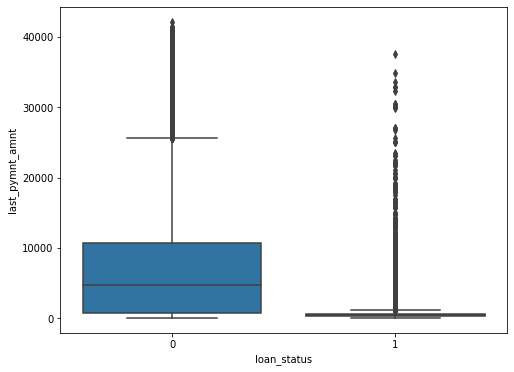

In [17]:
sns.boxplot(x='loan_status',y='last_pymnt_amnt',data=df)

* last_pymnt_amnt is good predictor variable but not availble to the lender during loan lending process.

In [18]:
df.drop(['last_pymnt_amnt'],axis=1,inplace=True)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.20, random_state=100)

In [21]:
df_train = pd.DataFrame(y_train)
df_train[0].value_counts()/len(df_train)

0    0.800248
1    0.199752
Name: 0, dtype: float64

In [22]:
#from imblearn.over_sampling import SMOTE

In [23]:
#sm = SMOTE(sampling_strategy='minority', random_state=42)
#X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [24]:
#df_test = pd.DataFrame(y_test)
#df_test[0].value_counts()/len(df_test)

In [25]:
#df_train_sm = pd.DataFrame(y_train_sm)
#df_train_sm[0].value_counts()/len(df_train_sm)

## Scale  data after train test split

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()

In [28]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train

## Sequntial Model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [30]:
model = Sequential()
# input layer
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))

# hidden layear
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [31]:
#Early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [32]:
# Model fit
model.fit(x=X_train, 
          y=y_train, 
          epochs=7,
          batch_size=128,
          validation_data=(X_test, y_test),callbacks=[es])

Train on 790029 samples, validate on 197508 samples
Epoch 1/7
790029/790029 [==============================] - 13s 17us/step - loss: 0.2663 - val_loss: 0.2431
Epoch 2/7
790029/790029 [==============================] - 12s 16us/step - loss: 0.2395 - val_loss: 0.2314
Epoch 3/7
790029/790029 [==============================] - 12s 16us/step - loss: 0.2315 - val_loss: 0.2228
Epoch 4/7
790029/790029 [==============================] - 13s 16us/step - loss: 0.2265 - val_loss: 0.2195
Epoch 5/7
790029/790029 [==============================] - 15s 19us/step - loss: 0.2240 - val_loss: 0.2187
Epoch 6/7
790029/790029 [==============================] - 14s 17us/step - loss: 0.2226 - val_loss: 0.2181
Epoch 7/7
790029/790029 [==============================] - 13s 16us/step - loss: 0.2216 - val_loss: 0.2152


In [33]:
losses = pd.DataFrame(model.history.history)

Text(0.5, 0, 'Number of epochs')

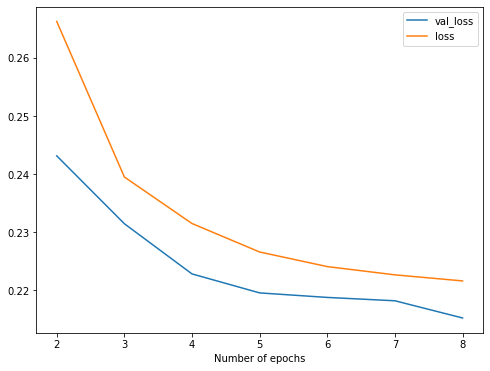

In [34]:
ax=losses.plot()
ax.set_xticklabels(np.arange(1,11))
plt.xlabel('Number of epochs')

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, matthews_corrcoef,f1_score

In [36]:
predictions_nw = model.predict_classes(X_test)

In [37]:
print(classification_report(y_test,predictions_nw,digits=3))

              precision    recall  f1-score   support

           0      0.922     0.949     0.935    158424
           1      0.767     0.674     0.718     39084

    accuracy                          0.895    197508
   macro avg      0.844     0.812     0.827    197508
weighted avg      0.891     0.895     0.892    197508



In [38]:
print(matthews_corrcoef(y_test,predictions_nw))

0.6554224308595896


In [39]:
con_mat = confusion_matrix(y_test,predictions_nw)
labels = ['Charged Off','Fully Paid']

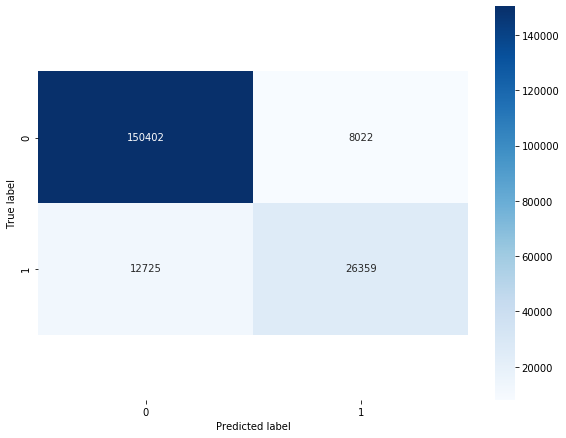

In [40]:
ax = sns.heatmap(con_mat, annot=True,fmt="d",cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
def new_costumer():
    import random
    random_ind = random.randint(0,len(X_test))

    #new_customer = df.drop('loan_paid',axis=1).iloc[random_ind]
    new_customer = pd.DataFrame(X_test).iloc[random_ind]
    predict = model.predict_classes(new_customer.values.reshape(1,X_train.shape[1]))[0][0]
    true = pd.DataFrame(y_test).iloc[random_ind][0]
    return true,predict

In [42]:
def sample_prediction(N):
    x = []
    y = []
    for _ in range(N):
        true,predict = new_costumer()
        x.append(true)
        y.append(predict)
    plt.figure(figsize=(15,5))
    plt.plot(x,'-r',label='True')
    plt.plot(y,'b^',label='Predicted')
    plt.legend()

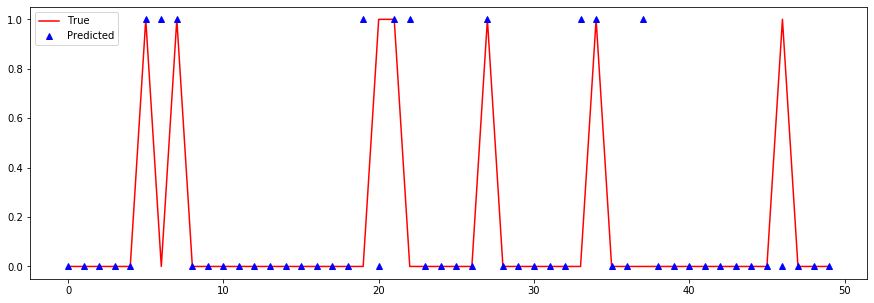

In [43]:
sample_prediction(50)

# Logistic regresion

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
predictions_lr = logmodel.predict(X_test)

In [47]:
print(classification_report(y_test,predictions_lr,digits=3))

              precision    recall  f1-score   support

           0      0.904     0.946     0.924    158424
           1      0.731     0.591     0.653     39084

    accuracy                          0.876    197508
   macro avg      0.817     0.769     0.789    197508
weighted avg      0.869     0.876     0.871    197508



In [48]:
print(f'matthews_corrcoef: {matthews_corrcoef(y_test,predictions_lr):g}')

matthews_corrcoef: 0.5837


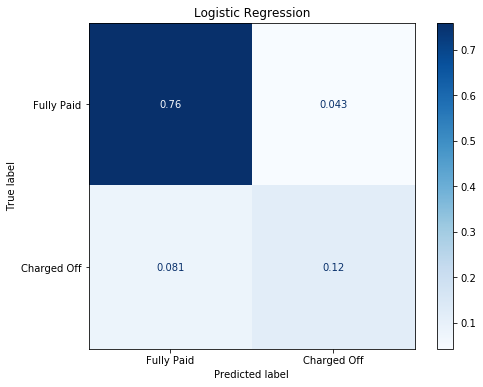

In [49]:
confusion_matrix_display(logmodel, 'Logistic Regression')

# Decision Tree Classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
dtree = DecisionTreeClassifier()

In [52]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [53]:
predictions_dt = dtree.predict(X_test)

In [54]:
print(classification_report(y_test,predictions_dt,digits=3))

              precision    recall  f1-score   support

           0      0.921     0.921     0.921    158424
           1      0.681     0.681     0.681     39084

    accuracy                          0.874    197508
   macro avg      0.801     0.801     0.801    197508
weighted avg      0.874     0.874     0.874    197508



In [55]:
print(matthews_corrcoef(y_test,predictions_nw))

0.6554224308595896


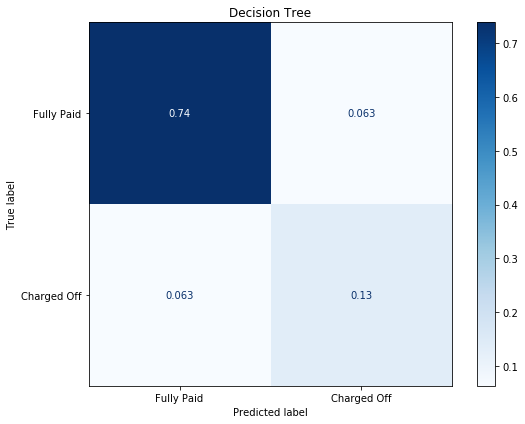

In [56]:
confusion_matrix_display(dtree, 'Decision Tree')
plt.tight_layout()

## Compare two models

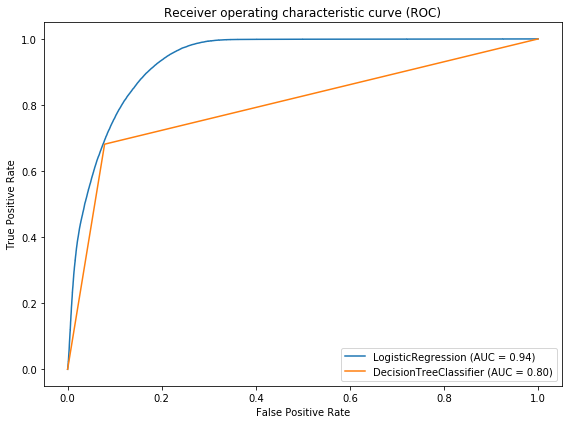

In [57]:
ax = plt.gca()
plot_roc_curve(logmodel, X_test, y_test,ax=ax)
plot_roc_curve(dtree, X_test, y_test,ax=ax)
plt.title('Receiver operating characteristic curve (ROC)')
plt.tight_layout()

**Both ROC curves are excellent with AUC values close to 1. The Logistic Regression is performing better than Decision Tree Classifier.**

# Future work

 * Investigate each feature carefully and keep only those features that are available to the investor before investing.
 * Adjust MV_FEATURE, CV_MAX, and PC_MAX in the features selection
 * Choose the best model and parameters 